# Sweep regions

---

Variables to allow differentation of file names for analyses based on different calling criteria. Should be commented out when run in batch with `slurm-jupyter-run.py`

**NB:** comment out the cell below if you want to run using `slurm-jupyter-run.py`. Otherwise it will overwrite variables set by `slurm-jupyter-run.py`.

In [1]:
from nb_parameters import extract_parameter_code
exec(extract_parameter_code('nb_parameters.ipynb', '5e-05_25%'))

----

Extract swept regions around peaks

In [2]:
import re, os, sys, pickle, pickle, subprocess, bisect, random
from pathlib import Path
import numpy
import pandas
from pandas import DataFrame, Series

import scipy

from ete3 import Tree
from scipy.cluster.hierarchy import dendrogram, linkage

import pyfaidx

# my own libaries
from ChromosomeWindows import window
import genominterv

numpy.random.seed(7)
random.seed(7)

/home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
import re, os, sys, pickle, math, collections, random
from pathlib import Path
import numpy
import pandas
from pandas import DataFrame
from ete3 import Tree
from scipy.cluster.hierarchy import dendrogram, linkage
import subprocess
import bisect
import pyfaidx

Plotting setup:

In [4]:
%matplotlib inline

# Make inline plots vector graphics instead of raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

#from mpl_toolkits.basemap import Basemap
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import mpld3

import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("whitegrid")
sns.set_context("paper")

# lowess for plotting
from statsmodels.nonparametric.smoothers_lowess import lowess

set1 = {'red': '#e41a1c', 'blue': '#377eb8', 'green': '#4daf4a',
        'purple': '#984ea3', 'orange': '#ff7f00', 
        'yellow': '#ffff33', 'brown': '#a65628'}

In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/kmt/anaconda3/e

Ignore deprecation warnings from mainly seaborn:

In [5]:
# silence deprecation warnings (lots from seaborn)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=numpy.VisibleDeprecationWarning)
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

### Analysis dirs

In [6]:
root_dir = Path(os.environ['HOME'], 'simons/faststorage/people/kmt')
meta_data_dir = Path(os.environ['HOME'], 'simons/faststorage/data/metadata')
steps_dir = root_dir / 'steps'
argweaver_dir = steps_dir / 'argweaver/output'
results_dir = root_dir / 'results'
figures_dir = root_dir / 'figures'
data_dir = root_dir / 'data'
pi_dir = steps_dir / 'pi_stores'
dist_dir = steps_dir / 'dist_stores'
#pi_dir = root_dir / 'old_pi_stores'
male_x_haploid_dir = steps_dir / 'male_x_haploids'

reference_genome_file = Path('/home', 'kmt', 'simons', 
                        'faststorage', 'cteam_lite_public3', 'FullyPublic', 'Href.fa')

Import variables global to the entire analysis:

In [7]:
import analysis_globals

Local code in the scripts dir on the cluster:

In [8]:
scripts_dir = root_dir / 'scripts'
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import simons_meta_data
import hg19_chrom_sizes

from toggle_code_and_errors import toggle_code_html, toggle_errors_html

## Convenience functions

In [9]:
def silent_nanmean(x):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return numpy.nanmean(x)
    
def ident_scalar(s):
    x = s.unique()
    assert(len(x)) == 1
    return x[0]

def flatten_column_index(df):
    df.columns = ['_'.join(col).strip() for col in df.columns.values]


In [10]:
import time
class Timer:    
    def __enter__(self):
        self.start = time.clock()
        return self

    def __exit__(self, *args):
        self.end = time.clock()
        self.interval = self.end - self.start
        print("{:.0f} min {:.1f} sec".format(self.interval//60, self.interval % 60))

## Load meta data

In [11]:
# easy loading of meta data in a consistent manner across code
individuals, populations, regions = simons_meta_data.get_meta_data(meta_data_dir=meta_data_dir)

pop_categories = pandas.read_hdf(str(results_dir / 'population_categories.store'), 'sr')
region_categories = pandas.read_hdf(str(results_dir / 'region_categories.store'), 'sr')

region_colors = dict(zip(list(region_categories), 
                         ['#e41a1c', '#377eb8',  '#984ea3', '#4daf4a',
                          '#ff7f00', '#ffff33', '#a65628']))

chromosome_lengths = dict((k.replace('chr', ''), v) for k, v in hg19_chrom_sizes.hg19_chrom_sizes.items())

## Load sweep data

In [12]:
non_afr_total_swept = pandas.read_hdf(results_dir / f'non_afr_total_swept_{ech_calling_tag}.hdf')
afr_total_swept = pandas.read_hdf(results_dir / f'afr_total_swept_{ech_calling_tag}.hdf')
sweep_peaks = pandas.read_hdf(results_dir / f'sweep_peaks_{ech_calling_tag}.hdf')
sweep_data = pandas.read_hdf(results_dir / f'sweep_data_{ech_calling_tag}.hdf')

In [13]:
sweep_peaks.head()

,start,end,prop_swept,pos
run_id,,,,
1,19800000,19900000,0.828571,19850000.0
2,21200000,21300000,0.814286,21250000.0
3,36200000,36400000,0.664286,36300000.0
4,37300000,37700000,0.507143,37500000.0
5,49500000,50000000,0.528571,49750000.0


In [14]:
non_afr_total_swept.head()

,index,start,end,is_non_african,nr_swept,total,pos,prop_swept
0,1,2700000,2800000,True,0,139,2750000.0,0.0
1,3,2800000,2900000,True,0,140,2850000.0,0.0
2,5,2900000,3000000,True,0,140,2950000.0,0.0
3,7,3000000,3100000,True,0,140,3050000.0,0.0
4,9,3100000,3200000,True,0,140,3150000.0,0.0


Make sure the index is 0, 1, 2 ...

In [15]:
non_afr_total_swept.reset_index(drop=True, inplace=True)
print(len(non_afr_total_swept))
non_afr_total_swept.tail()

1385


,index,start,end,is_non_african,nr_swept,total,pos,prop_swept
1380,2760,154100000,154200000,True,44,140,154150000.0,0.314286
1381,2762,154200000,154300000,True,44,140,154250000.0,0.314286
1382,2764,154300000,154400000,True,44,140,154350000.0,0.314286
1383,2766,154400000,154500000,True,40,140,154450000.0,0.285714
1384,2768,154800000,154900000,True,0,140,154850000.0,0.000000


For each peak find a region around the peak that spans 1Mb and includes as many individuals as possible.

In [16]:
def get_extended_region(df, peak_pos, max_width, min_sub_prop):
    
    peak_idx = non_afr_total_swept.loc[lambda df: (df.start <= peak_pos) & (df.end > peak_pos)].index[0]
    start_idx, end_idx = peak_idx, peak_idx
    peak_prop_swept = df.prop_swept[start_idx]
    cutoff = peak_prop_swept
    prev_cutoff = peak_prop_swept
    while df.end[end_idx] - df.start[start_idx] < max_width:
    
        if start_idx-2 < 0 or end_idx+2 >= len(df.end):
            break
    
        # if largest of left and right falls below cutoff we break:
        if max(df.prop_swept[start_idx-1], df.prop_swept[end_idx+1]) <= peak_prop_swept * min_sub_prop:
            # we still want this to represent the peak
            break
        
        # extend to the left:
        if df.prop_swept[start_idx-1] > df.prop_swept[end_idx+1]:
            cutoff = df.prop_swept[start_idx-1]
#             if cutoff > prev_cutoff: # if cutoff incease we are overlapping a different sweep
            if cutoff > prev_cutoff and df.prop_swept[start_idx-2] > prev_cutoff: # if cutoff incease we are overlapping a different sweep
                break
            start_idx -= 1
        # extend to the right:
        else:
            cutoff = df.prop_swept[end_idx+1]
#             if cutoff > prev_cutoff: # if cutoff incease we are overlapping a different sweep
            if cutoff > prev_cutoff and df.prop_swept[end_idx+2] > prev_cutoff:
                break
            end_idx += 1

        prev_cutoff = cutoff
            
    return df.start[start_idx], df.end[end_idx], prev_cutoff

## Get the extended regions around peaks

Extract the region around each peak where some percentage of the peak prop_swept is included.

**Note:** in the dataframes for such regions `prop_swept` does *not* refer to the peak but to a minimum proportion of individuals swept across the region.

In [17]:
for min_sub_prop in [0.1, 0.75, 0.9]:

    extended_regions = list()

    for tup in sweep_peaks.itertuples():

        # get extended region
        start_pos, end_pos, prop_swept = get_extended_region(non_afr_total_swept, tup.pos, 1e9, min_sub_prop)
        
        # get the relevant windows of the chromosome
        df = sweep_data.loc[lambda df: (df.start >= start_pos) & \
                            (df.end <= end_pos) & \
                            (df.swept)]

        # get swept the relevant windows of the chromosome: 
        # get only windows from individuals that are swept across the entire region
        df = df.groupby('indiv_1').filter(lambda df: len(df.index) == (end_pos - start_pos)/100000)

        # get the individuals
        swept_indivs = df.indiv_1.unique().tolist()

        # sanity check
        expected = len(swept_indivs)*(end_pos - start_pos)/100000
        assert expected == len(df.index)
        
        extended_regions.append((tup.pos, tup.start, tup.end, tup.prop_swept, start_pos, end_pos, prop_swept, swept_indivs))

        
    extended_peak_regions = DataFrame().from_records(extended_regions, 
                                   columns=['pos', 'peak_start', 'peak_end', 'peak_prop_swept', 'start_pos', 'end_pos', 
                                            'prop_swept', 'swept_indivs'])

    extended_peak_regions.swept_indivs = [repr(x) for x in extended_peak_regions.swept_indivs]
    extended_peak_regions.to_hdf(results_dir / f'extended_peak_regions_{ech_calling_tag}_{min_sub_prop*100:.0f}%.hdf', 'df', format='table', mode='w')



Write one of the sets of extended regions to pickle file for using for dating them:

In [18]:
extended_peak_regions_10 = pandas.read_hdf(results_dir / f'extended_peak_regions_{ech_calling_tag}_10%.hdf')
(extended_peak_regions_10
 .drop('swept_indivs', axis=1)
 .sort_values(by='pos')
 .assign(prop_swept=lambda df: df.prop_swept.round(2),
        pos=lambda df: df.pos.astype(int))
 .to_csv(results_dir / f'extended_peak_regions_{ech_calling_tag}_10%.csv', index=False)
)
extended_peak_regions_75 = pandas.read_hdf(results_dir / f'extended_peak_regions_{ech_calling_tag}_75%.hdf')
(extended_peak_regions_75
 .drop('swept_indivs', axis=1)
 .sort_values(by='pos')
 .assign(prop_swept=lambda df: df.prop_swept.round(2),
        pos=lambda df: df.pos.astype(int))
 .to_csv(results_dir / f'extended_peak_regions_{ech_calling_tag}_75%.csv', index=False)
)
extended_peak_regions_90 = pandas.read_hdf(results_dir / f'extended_peak_regions_{ech_calling_tag}_90%.hdf')
(extended_peak_regions_90
 .drop('swept_indivs', axis=1)
 .sort_values(by='pos')
 .assign(prop_swept=lambda df: df.prop_swept.round(2),
        pos=lambda df: df.pos.astype(int))
 .to_csv(results_dir / f'extended_peak_regions_{ech_calling_tag}_90%.csv', index=False)
)

In [19]:
"Total 90% region", extended_peak_regions_90.assign(length = lambda df: df.end_pos-df.start_pos).length.sum()

('Total 90% region', 9600000)

In [20]:
"Total 75% region", extended_peak_regions_75.assign(length = lambda df: df.end_pos-df.start_pos).length.sum()

('Total 75% region', 13300000)

In [21]:
10700000 / 155270560

0.06891196888837137

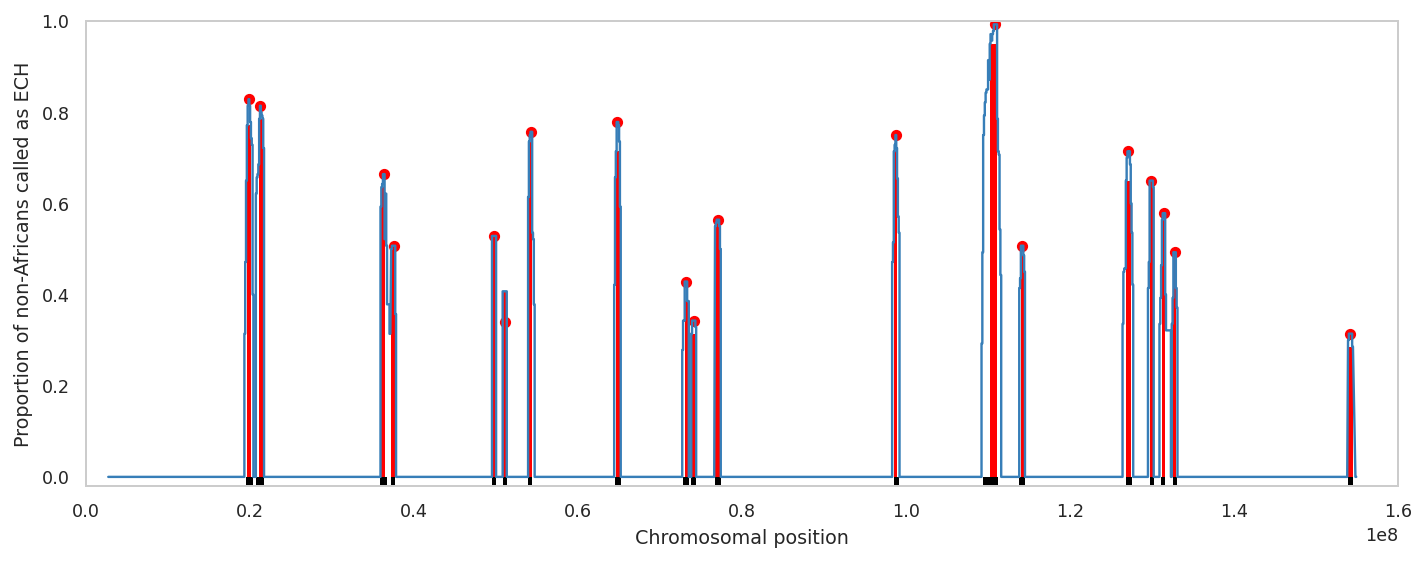

In [22]:
with sns.color_palette([set1['blue']]):
    with sns.axes_style("whitegrid", {'axes.grid' : False}):
        fig, ax = plt.subplots(figsize=(10, 4))

        x = [j for i in zip(non_afr_total_swept.start, non_afr_total_swept.end) for j in i]
        y = [j for i in zip(non_afr_total_swept.prop_swept, non_afr_total_swept.prop_swept) for j in i]      
        g = ax.plot(x, y)
        g = ax.scatter(sweep_peaks.pos, sweep_peaks.prop_swept, c='red')

        for tup in extended_peak_regions_90.itertuples():
            g = ax.add_patch(Rectangle((tup.start_pos, 0), tup.end_pos-tup.start_pos, tup.prop_swept, 
                         facecolor='red',
                         linewidth=0,
                         alpha=1.0,
                         zorder=1))

        for tup in extended_peak_regions_75.itertuples():
            g = ax.add_patch(Rectangle((tup.start_pos, -0.02), tup.end_pos-tup.start_pos, 0.02, 
                         facecolor='black',
                         linewidth=0,
                         alpha=1.0,
                         zorder=1))
            
        ax.set_ylim(-0.02,1)
        ax.set_xlim(0,160e6)

        ax.set_ylabel('Proportion of non-Africans called as ECH')
        ax.set_xlabel('Chromosomal position')
        
        plt.tight_layout()
        
        plt.savefig(str(figures_dir / f'tot_swept_ext_regions_{ech_calling_tag}.pdf')) 
        
#mpld3.display(fig)

In [23]:
(extended_peak_regions_90
 .assign(prop_swept_across=lambda df: [len(eval(x))/140 for x in df.swept_indivs])
 .assign(length=lambda df: df.end_pos-df.start_pos)
 .drop('swept_indivs', axis=1)
 .sort_values('pos', ascending=True)
)

,pos,peak_start,peak_end,peak_prop_swept,start_pos,end_pos,prop_swept,prop_swept_across,length
0,19850000.0,19800000,19900000,0.828571,19600000,20100000,0.771429,0.707143,500000
1,21250000.0,21200000,21300000,0.814286,21100000,21600000,0.785714,0.742857,500000
2,36300000.0,36200000,36400000,0.664286,36000000,36400000,0.635714,0.635714,400000
3,37500000.0,37300000,37700000,0.507143,37200000,37700000,0.500000,0.500000,500000
4,49750000.0,49500000,50000000,0.528571,49500000,50000000,0.528571,0.528571,500000
5,51100000.0,50800000,51400000,0.339286,50800000,51300000,0.407143,0.407143,500000
6,54300000.0,54200000,54400000,0.757143,54000000,54400000,0.735714,0.735714,400000
7,64800000.0,64700000,64900000,0.778571,64600000,65100000,0.714286,0.678571,500000
8,73150000.0,73000000,73300000,0.428571,73000000,73500000,0.385714,0.385714,500000
9,74100000.0,73900000,74300000,0.342857,73800000,74400000,0.314286,0.300000,600000


In [24]:
(extended_peak_regions_75
 .assign(prop_swept_across=lambda df: [len(eval(x))/140 for x in df.swept_indivs])
 .assign(length=lambda df: df.end_pos-df.start_pos)
 .drop('swept_indivs', axis=1)
 .sort_values('length', ascending=False)
)

,pos,peak_start,peak_end,peak_prop_swept,start_pos,end_pos,prop_swept,prop_swept_across,length
12,110900000.0,110700000,111100000,0.992857,109400000,111200000,0.750000,0.528571,1800000
1,21250000.0,21200000,21300000,0.814286,20700000,21700000,0.621429,0.521429,1000000
0,19850000.0,19800000,19900000,0.828571,19500000,20300000,0.650000,0.542857,800000
2,36300000.0,36200000,36400000,0.664286,35900000,36700000,0.507143,0.307143,800000
14,127050000.0,127000000,127100000,0.714286,126800000,127500000,0.600000,0.485714,700000
13,114150000.0,114000000,114300000,0.507143,113800000,114500000,0.414286,0.364286,700000
7,64800000.0,64700000,64900000,0.778571,64500000,65200000,0.592857,0.492857,700000
8,73150000.0,73000000,73300000,0.428571,72800000,73500000,0.342857,0.300000,700000
10,77050000.0,76900000,77200000,0.564286,76700000,77400000,0.500000,0.492857,700000
11,98750000.0,98700000,98800000,0.750000,98500000,99100000,0.571429,0.535714,600000


In [25]:
(extended_peak_regions_10
 .assign(prop_swept_across=lambda df: [len(eval(x))/140 for x in df.swept_indivs])
 .assign(length=lambda df: df.end_pos-df.start_pos)
 .drop('swept_indivs', axis=1)
 .sort_values('length', ascending=False)
)

,pos,peak_start,peak_end,peak_prop_swept,start_pos,end_pos,prop_swept,prop_swept_across,length
12,110900000.0,110700000,111100000,0.992857,109200000,111600000,0.292857,0.164286,2400000
16,131450000.0,131300000,131600000,0.578571,130900000,132300000,0.321429,0.064286,1400000
14,127050000.0,127000000,127100000,0.714286,126400000,127700000,0.335714,0.164286,1300000
2,36300000.0,36200000,36400000,0.664286,35900000,37100000,0.313869,0.157143,1200000
0,19850000.0,19800000,19900000,0.828571,19300000,20400000,0.314286,0.164286,1100000
1,21250000.0,21200000,21300000,0.814286,20700000,21700000,0.621429,0.521429,1000000
11,98750000.0,98700000,98800000,0.750000,98300000,99200000,0.471429,0.321429,900000
3,37500000.0,37300000,37700000,0.507143,37000000,37800000,0.313869,0.000000,800000
6,54300000.0,54200000,54400000,0.757143,53900000,54700000,0.378571,0.271429,800000
7,64800000.0,64700000,64900000,0.778571,64400000,65200000,0.421429,0.314286,800000


In [26]:
extended_peak_regions_10 = pandas.read_hdf(results_dir / f'extended_peak_regions_{ech_calling_tag}_10%.hdf')
(extended_peak_regions_10
 .drop('swept_indivs', axis=1)
 .sort_values(by='pos')
 .assign(prop_swept=lambda df: df.prop_swept.round(2),
        pos=lambda df: df.pos.astype(int))
 .to_csv(results_dir / f'extended_peak_regions_{ech_calling_tag}_10%.csv', index=False)
)

In [27]:
renaming = {'peak_start': 'peak start', 'peak_prop_swept': 'peak prop swept', 'peak_end': 'peak end',
            'start_pos': 'start', 'end_pos': 'end', 
            'prop_swept': 'Min freq. ECH', 'prop_swept_across': 'Freq. ECHs spanning region'}

df = ((extended_peak_regions_75 
       .assign(prop_swept=lambda df: df.prop_swept.round(2),
               prop_swept_across=lambda df: [round(len(eval(x))/140, 2) for x in df.swept_indivs],
               length=lambda df: df.end_pos - df.start_pos)
       .drop(['pos', 'swept_indivs'], axis=1)
      ).rename(columns=renaming)
      .merge((extended_peak_regions_90
             .assign(prop_swept=lambda df: df.prop_swept.round(2),
                     prop_swept_across=lambda df: [round(len(eval(x))/140, 2) for x in df.swept_indivs],
                     length=lambda df: df.end_pos - df.start_pos)
              .drop(['pos', 'swept_indivs'], axis=1)
             ).rename(columns=renaming), 
             on=['peak start', 'peak end', 'peak prop swept'],
             suffixes=(' (75%)', ' (90%)'))
     .sort_values(by='peak start')
     )

#df.to_csv(results_dir / 'ech_regions_som.csv', index=False)
df

,peak start,peak end,peak prop swept,start (75%),end (75%),Min freq. ECH (75%),Freq. ECHs spanning region (75%),length (75%),start (90%),end (90%),Min freq. ECH (90%),Freq. ECHs spanning region (90%),length (90%)
0,19800000,19900000,0.828571,19500000,20300000,0.65,0.54,800000,19600000,20100000,0.77,0.71,500000
1,21200000,21300000,0.814286,20700000,21700000,0.62,0.52,1000000,21100000,21600000,0.79,0.74,500000
2,36200000,36400000,0.664286,35900000,36700000,0.51,0.31,800000,36000000,36400000,0.64,0.64,400000
3,37300000,37700000,0.507143,37200000,37700000,0.50,0.50,500000,37200000,37700000,0.50,0.50,500000
4,49500000,50000000,0.528571,49500000,50000000,0.53,0.53,500000,49500000,50000000,0.53,0.53,500000
5,50800000,51400000,0.339286,50800000,51300000,0.41,0.41,500000,50800000,51300000,0.41,0.41,500000
6,54200000,54400000,0.757143,53900000,54400000,0.61,0.61,500000,54000000,54400000,0.74,0.74,400000
7,64700000,64900000,0.778571,64500000,65200000,0.59,0.49,700000,64600000,65100000,0.71,0.68,500000
8,73000000,73300000,0.428571,72800000,73500000,0.34,0.30,700000,73000000,73500000,0.39,0.39,500000
9,73900000,74300000,0.342857,73800000,74400000,0.31,0.30,600000,73800000,74400000,0.31,0.30,600000


## Prepare table for supplementary

**NB:** This table is ammended with an extra column in `nb_18_sweeps_and_dist_to_ust_ishim.ipynb`.

In [28]:
df = (((sweep_peaks[['pos', 'start', 'end', 'prop_swept']]
        .merge(extended_peak_regions_90, suffixes=('_peak', ''), 
               left_on=['pos', 'start', 'end'], right_on=['pos', 'peak_start', 'peak_end'])
       ).drop(['start', 'end'], axis=1)
        .assign(prop_swept_peak=lambda df: [round(x, 2) for x in df.prop_swept_peak] )

       .assign(prop_swept=lambda df: df.prop_swept.round(2),
               prop_swept_across=lambda df: [round(len(eval(x))/140, 2) for x in df.swept_indivs],
               peak_start = lambda df: (df.peak_start / 100000).astype('int'),
               peak_end = lambda df: (df.peak_end / 100000).astype('int'),
               start_pos=lambda df: (df.start_pos / 100000).astype('int'),
               end_pos=lambda df: (df.end_pos / 100000).astype('int'))
       .assign(length=lambda df: df.end_pos - df.start_pos)
       .drop(['swept_indivs'], axis=1)
      )[['pos', 'peak_start', 'peak_end', 'prop_swept_peak', 'start_pos', 'end_pos', 'length', 'prop_swept', 'prop_swept_across']]
      .merge((extended_peak_regions_75
             .assign(prop_swept=lambda df: df.prop_swept.round(2),
                     prop_swept_across=lambda df: [round(len(eval(x))/140, 2) for x in df.swept_indivs],
                     peak_start = lambda df: (df.peak_start / 100000).astype('int'),
                     peak_end = lambda df: (df.peak_end / 100000).astype('int'),
                     start_pos=lambda df: (df.start_pos / 100000).astype('int'),
                     end_pos=lambda df: (df.end_pos / 100000).astype('int'))
              .assign(length=lambda df: df.end_pos - df.start_pos)
              .drop(['swept_indivs'], axis=1)
             )[['pos', 'peak_start', 'peak_end', 'start_pos', 'end_pos', 'length', 'prop_swept', 'prop_swept_across']], 
             on=['pos', 'peak_start', 'peak_end'],
             suffixes=(' (90%)', ' (75%)'))
     .sort_values(by=['peak_start'])
     )

df.columns = pandas.MultiIndex(levels=[['Peak', '90%-region', '75%-region'], 
                                       ['pos', 'Start', 'End', 'Freq. ECH', 'Length', 'Min freq. ECH', 'Freq. ECHs spanning region']], 
                               codes=[[0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2], 
                                       [0, 1, 2, 3, 1, 2, 4, 5, 6, 1, 2, 4, 5, 6]])
df = df.drop(('Peak', 'pos'), axis=1)

df[('Data S1', 'Subplot')] = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ$%&#@*'[:len(df)])

df.to_hdf(results_dir / f'ech_regions_som_multidx_{ech_calling_tag}.hdf', 'df', format='table')

df

Peak                 90%-region                             \
   Start   End Freq. ECH      Start   End Length Min freq. ECH   
0    198   199      0.83        196   201      5          0.77   
1    212   213      0.81        211   216      5          0.79   
2    362   364      0.66        360   364      4          0.64   
3    373   377      0.51        372   377      5          0.50   
4    495   500      0.53        495   500      5          0.53   
5    508   514      0.34        508   513      5          0.41   
6    542   544      0.76        540   544      4          0.74   
7    647   649      0.78        646   651      5          0.71   
8    730   733      0.43        730   735      5          0.39   
9    739   743      0.34        738   744      6          0.31   
10   769   772      0.56        767   773      6          0.55   
11   987   988      0.75        985   989      4          0.71   
12  1107  1111      0.99       1102  1111      9          0.95   
13  1140  1143      0.51       1140  1144      4          0.49   
14  1270  1271      0.71       1268  1274      6          0.65   
15  1297  1301      0.65       1297  1302      5          0.64   
16  1313  1316      0.58       1312  1316      4          0.56   
17  1326  1329      0.49       1326  1329      3          0.49   
18  1540  1544      0.31       1539  1545      6          0.29   

                              75%-region                             \
   Freq. ECHs spanning region      Start   End Length Min freq. ECH   
0                        0.71        195   203      8          0.65   
1                        0.74        207   217     10          0.62   
2                        0.64        359   367      8          0.51   
3                        0.50        372   377      5          0.50   
4                        0.53        495   500      5          0.53   
5                        0.41        508   513      5          0.41   
6                        0.74        539   544      5          0.61   
7                        0.68        645   652      7          0.59   
8                        0.39        728   735      7          0.34   
9                        0.30        738   744      6          0.31   
10                       0.54        767   774      7          0.50   
11                       0.69        985   991      6          0.57   
12                       0.91       1094  1112     18          0.75   
13                       0.49       1138  1145      7          0.41   
14                       0.57       1268  1275      7          0.60   
15                       0.64       1297  1302      5          0.64   
16                       0.56       1311  1316      5          0.46   
17                       0.49       1325  1331      6          0.37   
18                       0.27       1539  1545      6          0.29   

                              Data S1  
   Freq. ECHs spanning region Subplot  
0                        0.54       A  
1                        0.52       B  
2                        0.31       C  
3                        0.50       D  
4                        0.53       E  
5                        0.41       F  
6                        0.61       G  
7                        0.49       H  
8                        0.30       I  
9                        0.30       J  
10                       0.49       K  
11                       0.54       L  
12                       0.53       M  
13                       0.36       N  
14                       0.49       O  
15                       0.64       P  
16                       0.46       Q  
17                       0.27       R  
18                       0.27       S

## relative TMRCA_half in extended regions

We use the 90% set for this and only regions with enough individuals swept that we call them as sweeps.


In [29]:
tmrca_stats_world = pandas.read_hdf(results_dir / 'pruned_tmrca_stats.hdf')
tmrca_stats_world.head()

,start,end,chain,MCMC_sample,coal_half,tmrca,tmrca_half,rel_tmrca_half
0,0,100000,1.5,2750.0,226.957517,45083.337393,12645.212660,0.281658
1,100000,200000,1.5,2750.0,362.848331,47935.198573,14351.381341,0.300756
2,200000,300000,1.5,2750.0,551.114128,53009.238578,19172.584913,0.363367
3,300000,400000,1.5,2750.0,495.469935,50038.851797,14837.471573,0.297887
4,400000,500000,1.5,2750.0,513.143674,50557.752598,18956.576133,0.376540


In [30]:
extended_peak_regions_90.loc[lambda df: df.peak_prop_swept >= analysis_globals.min_prop_swept]

,pos,peak_start,peak_end,peak_prop_swept,start_pos,end_pos,prop_swept,swept_indivs
0,19850000.0,19800000,19900000,0.828571,19600000,20100000,0.771429,"['B_Australian-4', 'B_Crete-2', 'B_Dai-4', 'B_..."
1,21250000.0,21200000,21300000,0.814286,21100000,21600000,0.785714,"['B_Australian-4', 'B_Crete-2', 'B_French-3', ..."
2,36300000.0,36200000,36400000,0.664286,36000000,36400000,0.635714,"['B_Crete-2', 'B_Dai-4', 'B_French-3', 'B_Han-..."
3,37500000.0,37300000,37700000,0.507143,37200000,37700000,0.500000,"['B_Crete-2', 'B_Dai-4', 'B_Han-3', 'B_Karitia..."
4,49750000.0,49500000,50000000,0.528571,49500000,50000000,0.528571,"['B_Australian-4', 'B_French-3', 'B_Papuan-15'..."
6,54300000.0,54200000,54400000,0.757143,54000000,54400000,0.735714,"['B_Australian-4', 'B_Crete-2', 'B_Dai-4', 'B_..."
7,64800000.0,64700000,64900000,0.778571,64600000,65100000,0.714286,"['B_Crete-2', 'B_Dai-4', 'B_French-3', 'B_Han-..."
10,77050000.0,76900000,77200000,0.564286,76700000,77300000,0.550000,"['B_Australian-4', 'B_French-3', 'B_Sardinian-..."
11,98750000.0,98700000,98800000,0.750000,98500000,98900000,0.714286,"['B_Dai-4', 'B_French-3', 'B_Han-3', 'B_Kariti..."
12,110900000.0,110700000,111100000,0.992857,110200000,111100000,0.950000,"['B_Australian-4', 'B_Crete-2', 'B_Dai-4', 'B_..."


In [31]:
global_mean = tmrca_stats_world.rel_tmrca_half.mean()
print('global mean rel_tmrca_half:', global_mean)

global mean rel_tmrca_half: 0.15111084869573296


In [32]:
def get_rel_tmrca_half(df):
    s, e = df.start_pos.iloc[0], df.end_pos.iloc[0]
    return tmrca_stats_world.loc[lambda df: (df.start >= s) & (df.end <= e)]

In [33]:
sr = (extended_peak_regions_90.loc[lambda df: df.prop_swept >= 0.25]
           .groupby(['pos', 'prop_swept']).apply(get_rel_tmrca_half).reset_index()
          )['rel_tmrca_half']
print('mean rel_tmrca_half for all sweeps:', sr.mean())
print(scipy.stats.ttest_ind(tmrca_stats_world.rel_tmrca_half, sr))

mean rel_tmrca_half for all sweeps: 0.05207449955453203
Ttest_indResult(statistic=8.740616086011128, pvalue=5.603687673269481e-18)


In [34]:
sr = (extended_peak_regions_90.loc[lambda df: df.peak_prop_swept >= analysis_globals.min_prop_swept]
           .groupby(['pos', 'prop_swept']).apply(get_rel_tmrca_half).reset_index()
          )['rel_tmrca_half']
print('mean rel_tmrca_half for all sweeps:', sr.mean())
print(scipy.stats.ttest_ind(tmrca_stats_world.rel_tmrca_half, sr))

mean rel_tmrca_half for all sweeps: 0.03196226936711654
Ttest_indResult(statistic=9.119627024862819, pvalue=2.1682263561194884e-19)


## Width of ECHs by geographical region

**Idea:** It is possible that X variants followed the successive invasions of populations across Eurasia from an East Asian origin.
If true, the further away from East Asia, the more time there has been for recombination to decouple flanking regions originally received from the contributing population. So if we compare the width of ECHs around the peak we should see wider ECHs in East Asia than in Europe.

**NB:** For now we just do `sweep_coord`, but we should also do `sweep_coord_af`. However, here we need to handle the gaps in ECHs induce by admixture masking.

In [35]:
sweep_coord = pandas.read_hdf(results_dir / f'sweep_coord_{ech_calling_tag}.hdf')
sweep_coord.head()

,indiv_1,run_id,start,end,mean_dist,region_label_1,pop_1
0,B_Australian-4,2,19500000,20300000,0.000146,Oceania,Australian
1,B_Australian-4,4,20700000,21700000,0.000126,Oceania,Australian
2,B_Australian-4,6,49500000,50000000,0.000133,Oceania,Australian
3,B_Australian-4,8,50800000,51300000,0.000210,Oceania,Australian
4,B_Australian-4,10,53900000,54700000,0.000145,Oceania,Australian


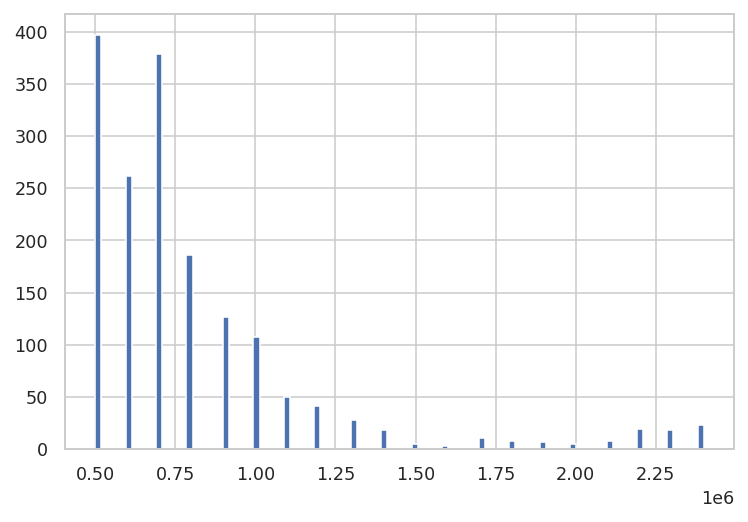

In [36]:
plt.hist(sweep_coord.end - sweep_coord.start, bins=100) ;

In [37]:
peak_pos = []
for segment in sweep_coord.itertuples():
    r = ((extended_peak_regions_90.peak_end > segment.start) & (segment.end > extended_peak_regions_90.peak_start)).values
    if not any(r):
        peak_pos.append(numpy.nan)#print('NAN', segment.indiv_1, segment.start, segment.end)
    else:
        peak_pos.append(extended_peak_regions_90.pos[numpy.argwhere(r)[0, 0]])
sweep_coord['peak_pos'] = peak_pos
sweep_coord['length'] = sweep_coord.end - sweep_coord.start
sweep_coord = sweep_coord.loc[~numpy.isnan(sweep_coord.peak_pos), :]
sweep_coord.head()

,indiv_1,run_id,start,end,mean_dist,region_label_1,pop_1,peak_pos,length
0,B_Australian-4,2,19500000,20300000,0.000146,Oceania,Australian,19850000.0,800000
1,B_Australian-4,4,20700000,21700000,0.000126,Oceania,Australian,21250000.0,1000000
2,B_Australian-4,6,49500000,50000000,0.000133,Oceania,Australian,49750000.0,500000
3,B_Australian-4,8,50800000,51300000,0.000210,Oceania,Australian,51100000.0,500000
4,B_Australian-4,10,53900000,54700000,0.000145,Oceania,Australian,54300000.0,800000


In [38]:
mean_widths = sweep_coord.groupby(['peak_pos', 'region_label_1']).length.mean()
mean_widths.unstack()

region_label_1,Africa,America,CentralAsiaSiberia,EastAsia,Oceania,SouthAsia,WestEurasia
peak_pos,,,,,,,
19850000.0,NaN,1012500.0,8.750000e+05,9.583333e+05,8.100000e+05,8.777778e+05,8.076923e+05
21250000.0,NaN,1000000.0,8.375000e+05,8.600000e+05,8.785714e+05,8.965517e+05,8.971429e+05
36300000.0,NaN,800000.0,1.014286e+06,8.833333e+05,6.500000e+05,6.368421e+05,8.684211e+05
37500000.0,NaN,600000.0,5.714286e+05,5.684211e+05,5.500000e+05,5.769231e+05,5.640000e+05
49750000.0,NaN,500000.0,5.000000e+05,5.000000e+05,5.000000e+05,5.000000e+05,5.000000e+05
51100000.0,NaN,500000.0,5.000000e+05,5.000000e+05,5.000000e+05,5.000000e+05,5.000000e+05
54300000.0,NaN,712500.0,5.750000e+05,6.200000e+05,7.000000e+05,6.888889e+05,6.794118e+05
64800000.0,700000.0,775000.0,7.000000e+05,6.869565e+05,6.625000e+05,7.173913e+05,6.897436e+05
73150000.0,500000.0,750000.0,8.000000e+05,8.000000e+05,5.875000e+05,6.769231e+05,7.333333e+05


In [39]:
plot_df = mean_widths.to_frame('mean_length').reset_index()
plot_df['region_label_1'] = pandas.Categorical(plot_df.region_label_1, 
                    categories=region_categories, ordered=True)

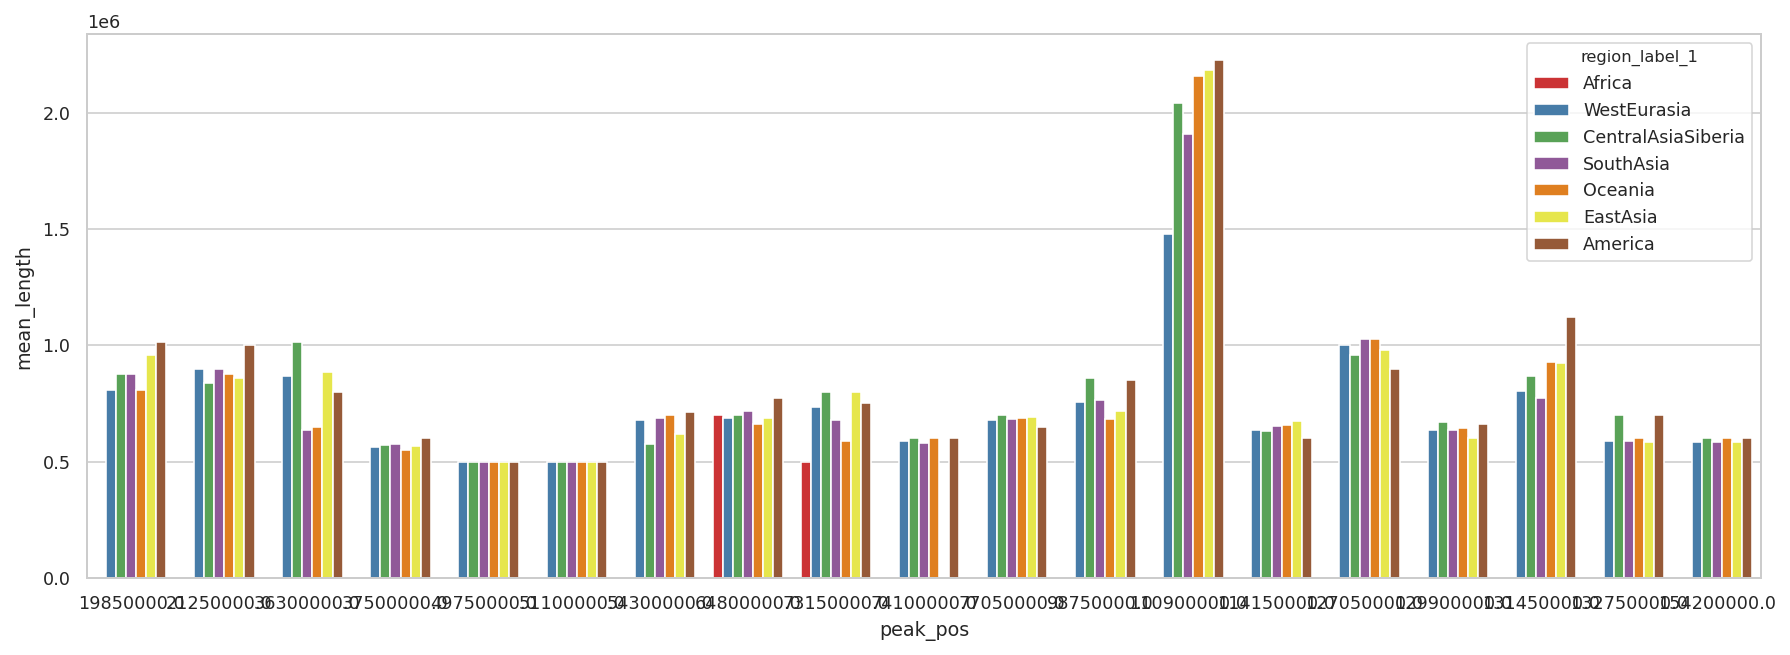

In [40]:
with sns.color_palette("Set1", 7):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    sns.barplot(data=plot_df, x='peak_pos', y='mean_length', hue='region_label_1', 
                ci=None, ax=ax)


## maps

Load population locations:

In [41]:
with open(str(results_dir / 'pop_locations.pkl'), 'rb') as f:
    pop_locations = pickle.load(f)

In [42]:
records = []
for pop, (lat, lon) in pop_locations.items():
    for indiv in populations[pop]:
#         records.append((indiv, round(lon, 1), round(lat, 1)))
        records.append((indiv, round(individuals[indiv]['Longitude'], 1), round(individuals[indiv]['Latitude'], 1)))
lon_lat_df = pandas.DataFrame().from_records(records, columns=['indiv_1', 'lon', 'lat'])

geo_df = sweep_coord.merge(lon_lat_df, how='left', on='indiv_1')

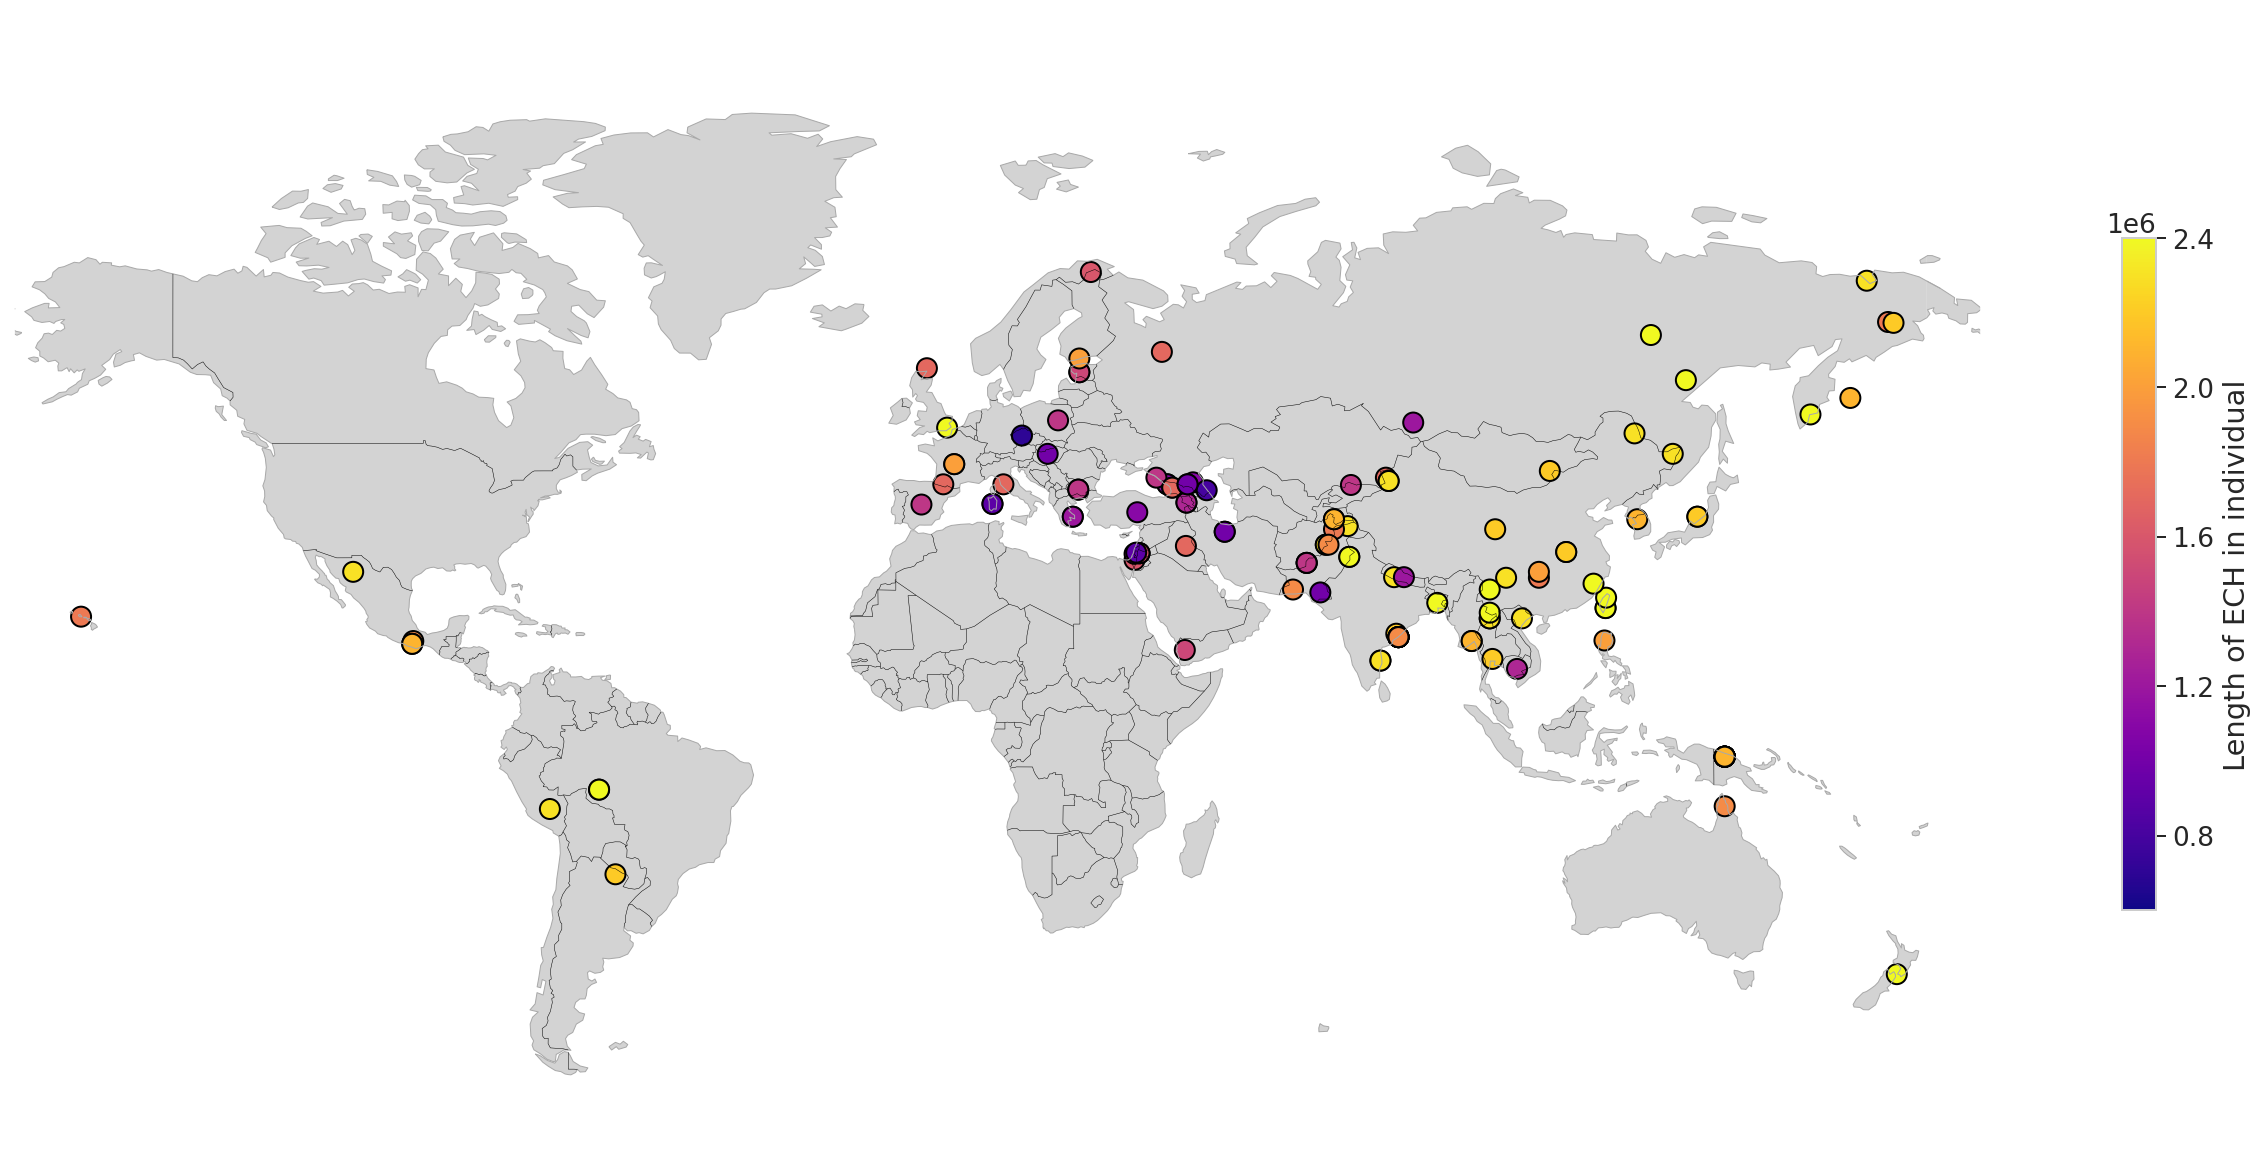

In [67]:
plot_df = geo_df.loc[geo_df.peak_pos == 110900000.0]

import cartopy
import cartopy.crs as ccrs

with sns.plotting_context('paper', font_scale=1.5):
    projection=ccrs.Miller(central_longitude=10.0)
    #projection=ccrs.PlateCarree(central_longitude=10.0)a
    resolution='110m'
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(1, 1, 1, projection=projection)

    ax.coastlines(color='darkgrey', resolution=resolution, linewidth=0.5)
    ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=.25)
    ax.add_feature(cartopy.feature.LAND, zorder=0, linewidth=.001, facecolor='lightgrey')
    ax.outline_patch.set_edgecolor('white')
    #ax.set_extent([-180, 180, 90, -63])
    ax.set_extent([-170, 179, 90, -63])

    sc = ax.scatter(plot_df.lon, plot_df.lat, s=100, 
                    c=plot_df.length, alpha=1, 
                    cmap='plasma', linewidth=1, edgecolors='black',
                    transform=ccrs.PlateCarree()) ;
    
#     from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    
#     axins1 = inset_axes(ax,
#                     width="10%",  # width = 50% of parent_bbox width
#                     height="50%",  # height : 5%
#                     loc='center left')
#    fig.colorbar(sc, cax=axins1, orientation="vertical", ticks=[1, 2, 3])


    cb = plt.colorbar(sc, shrink=0.6, label='Length of ECH in individual')

    from matplotlib import ticker

    tick_locator = ticker.MaxNLocator(nbins=5)
    cb.locator = tick_locator
    cb.update_ticks()
    

    for x, y in zip(plot_df.lon, plot_df.lat):
        pop = ''#plot_df.loc[(plot_df.lon == x) & (plot_df.lat == y), 'pop_1'][0]
        ax.text(x, y, pop, transform=ccrs.PlateCarree()) ;
        
    plt.tight_layout()
        
    plt.savefig(figures_dir / f'ech_width_world_map_largest_peak_{ech_calling_tag}.pdf')

/home/kmt/anaconda3/envs/simons/lib/python3.6/site-packages/seaborn/axisgrid.py:375: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


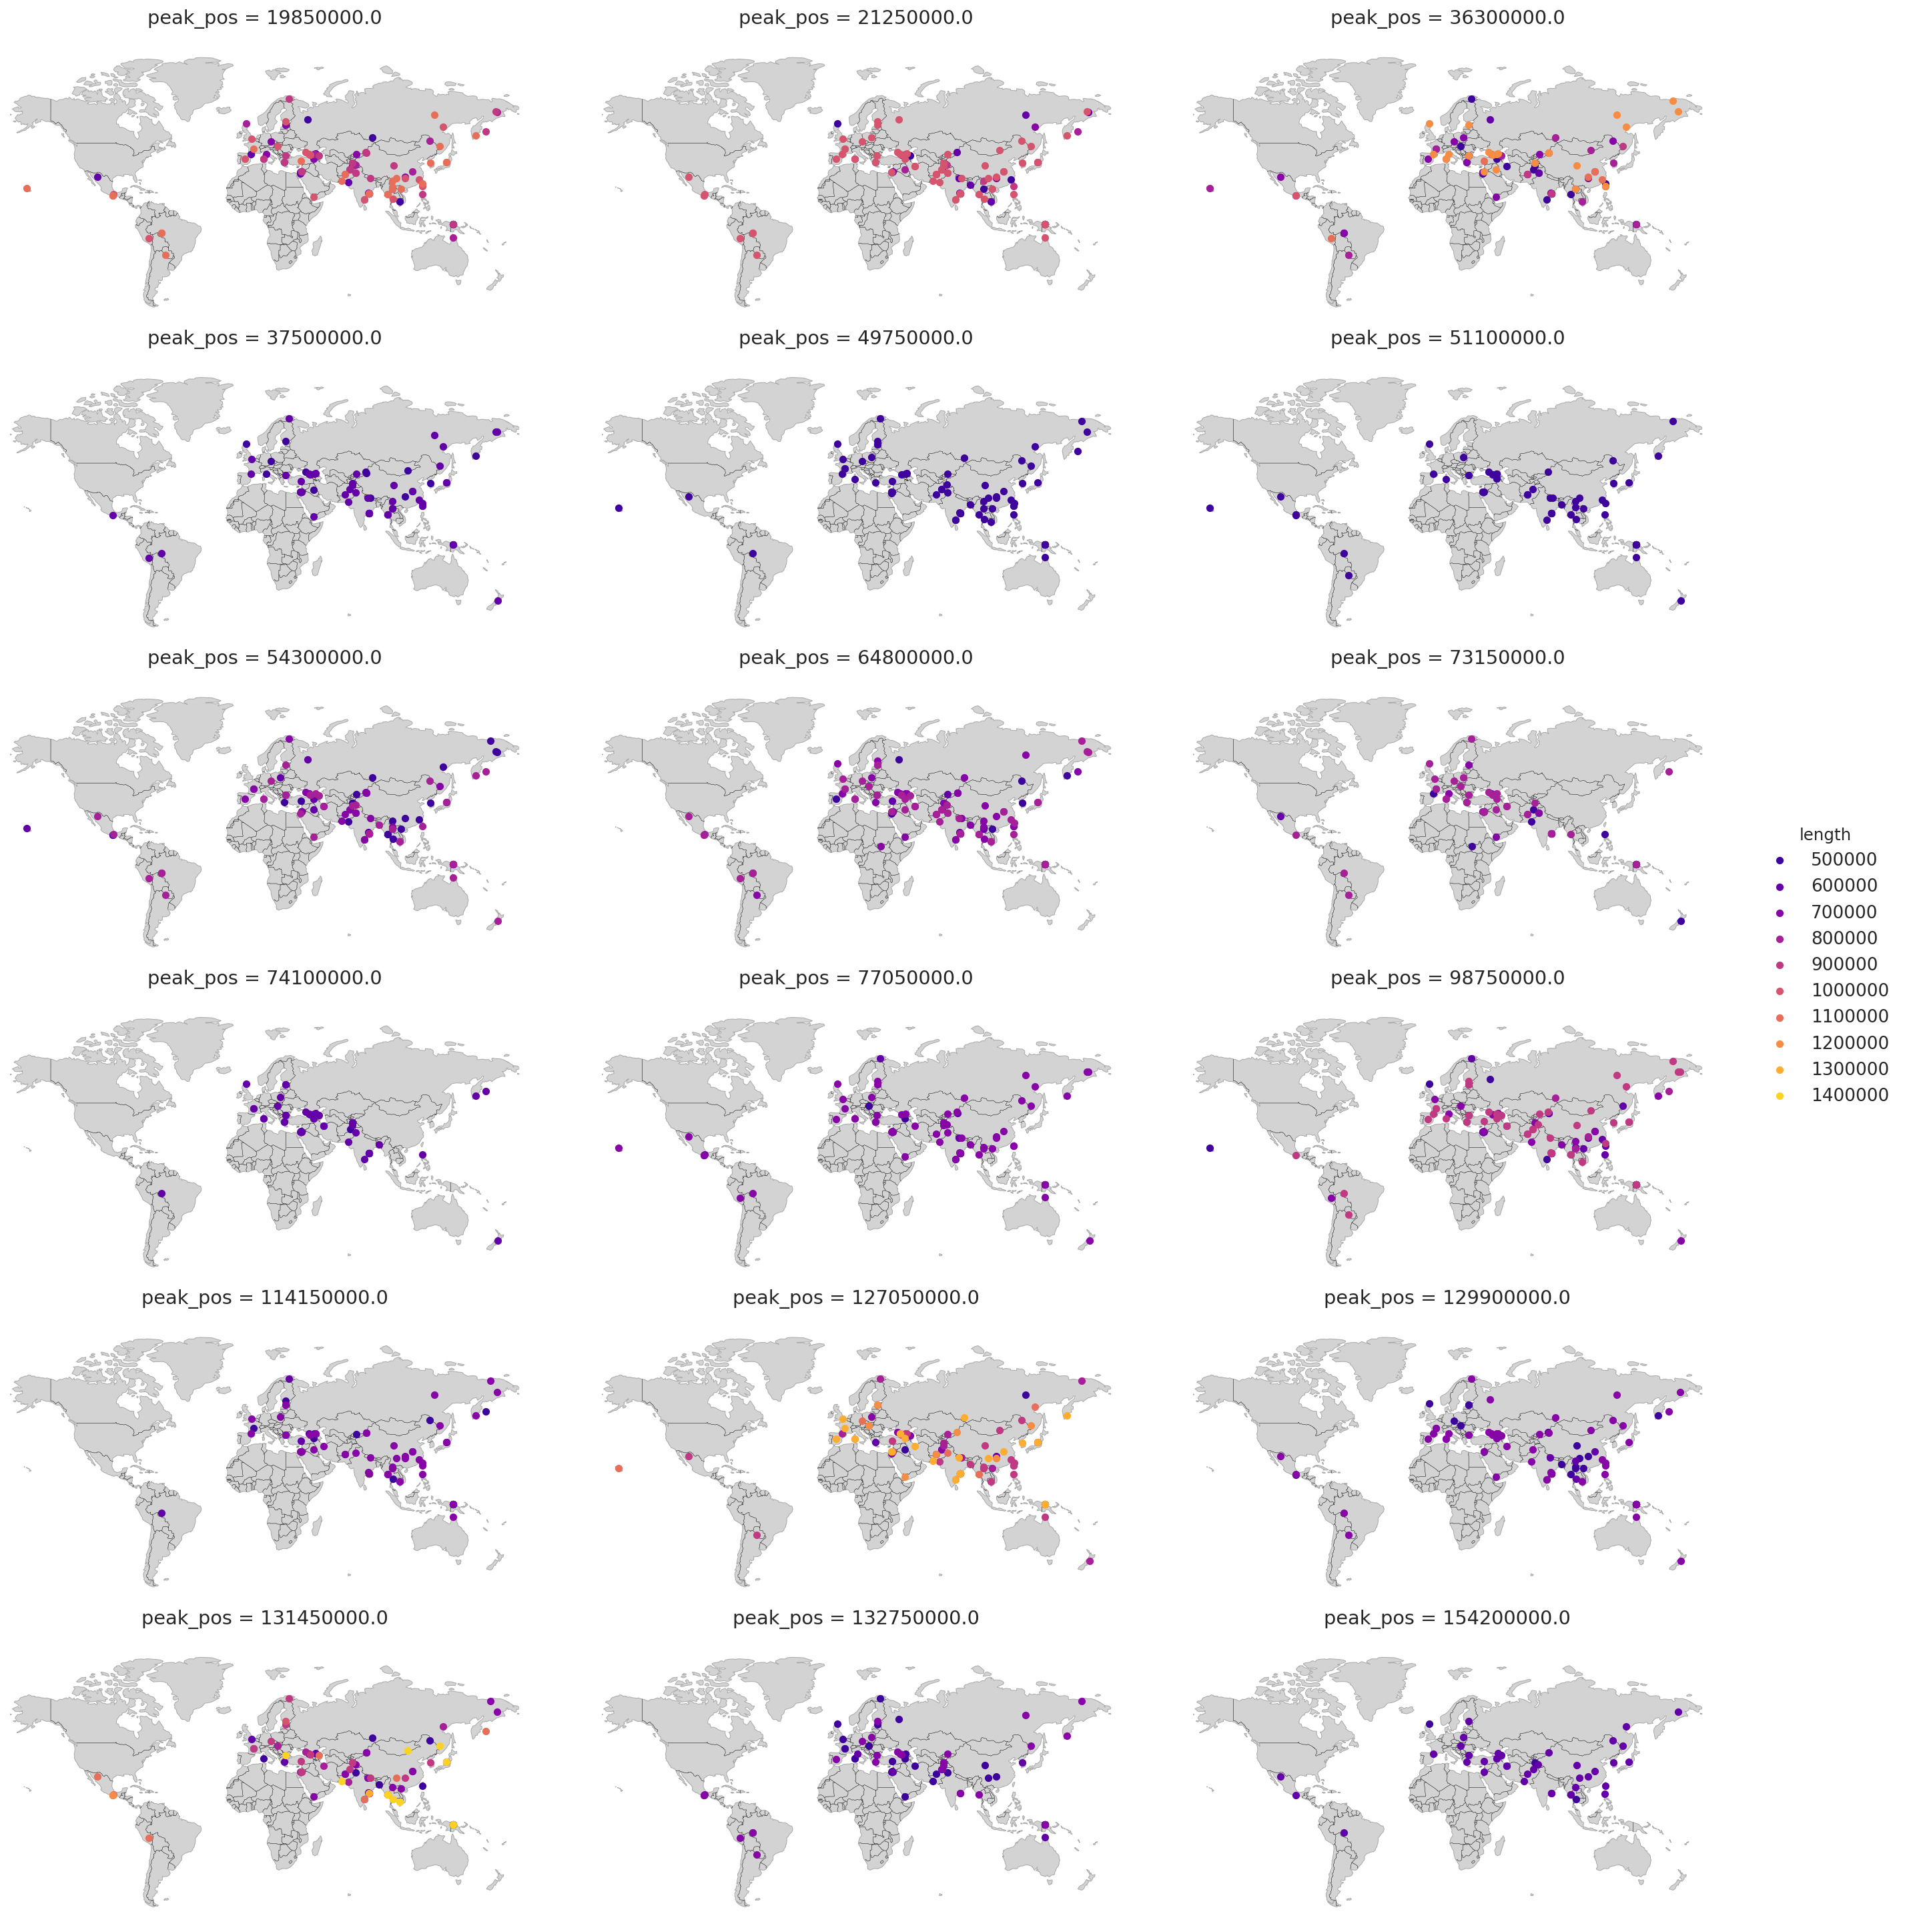

In [44]:
plot_df = geo_df.loc[geo_df.peak_pos != 110900000.0]

with sns.plotting_context('paper', font_scale=1.5):
    g = sns.FacetGrid(plot_df, col="peak_pos", hue='length',
                      col_wrap=3, height=3.5, aspect=1.8, palette='plasma',#sns.dark_palette('Red', 5),
                      subplot_kws=dict(projection=cartopy.crs.Miller(central_longitude=10.0)))
    g.map(plt.scatter, "lon", "lat", transform=cartopy.crs.PlateCarree(), zorder=10)

    for ax in g.axes.ravel():
        ax.coastlines(color='darkgrey', resolution=resolution, linewidth=0.5)
        ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=.25)
        ax.add_feature(cartopy.feature.LAND, zorder=0, linewidth=.001, facecolor='lightgrey')
        ax.outline_patch.set_edgecolor('white')
        plt.setp(ax.spines.values(), color='white') # set outline if missing
        ax.set_extent([-170, 179, 90, -63])

    g.fig.subplots_adjust(wspace=0, hspace=0.1)
    g.add_legend() ;
    plt.savefig(figures_dir / f'ech_width_world_map_remaining_peaks_{ech_calling_tag}.pdf')

## Extract SNPs shared by all swept individuals (for David)

We use the 90% set for this and only regions with enough individuals swept that we call them as sweeps.

We extract window for all non-Africans and get all positions segregating in non-Africans that are fixed in the swept non-African individuals. We discard positions with more than one base, with less than half of all bases called or with less than half of bases called in swept individuals.

Load sequence indexes:

In [45]:
# file_index = dict()
# for file_path in male_x_haploid_dir.glob('*.fa'):
#     name = file_path.name.split('.')[0]
#     file_index[name] = pyfaidx.Fasta(str(file_path), 
#                                      strict_bounds=True, 
#                                      one_based_attributes=False)
    
# reference_index = pyfaidx.Fasta(str(reference_genome_file), 
#                                  strict_bounds=True, 
#                                  one_based_attributes=False)
    
# def get_alignmnet(sample_ids, start, end):
#     assert start < end
#     start, end = int(start), int(end)
#     seq_list = list()
#     name_list = list()

#     for sample_id in sample_ids:
#         name = sample_id + '-A'   
#         seq_list.append(file_index[name]['X'][start:end].seq)
#         name_list.append(name.replace('-A', ''))
        
#     return name_list, seq_list

In [46]:
# from collections import Counter

# non_afr_indivs = sweep_data.loc[lambda df: df.region_1 != 'Africa', 'indiv_1'].unique()

# records = list()
# for tup in extended_peak_regions_90.loc[lambda df: df.peak_prop_swept >= analysis_globals.min_prop_swept].itertuples():

#     pos, start, end = tup.pos, tup.peak_start, tup.peak_end

#     # sequenes in window
#     names, aln = get_alignmnet(non_afr_indivs, start, end)    

#     # reference sequence
#     ref = reference_index['X'][start:end].seq
    
#     # get snp columns
#     snp_idx = dict()
#     for j in range(end-start):
#         col = [aln[i][j] for i in range(len(aln))]

#         if col.count('N') / len(non_afr_indivs) > 0.5:
#             continue

#         counter = Counter(col)

#         if 'N' in counter:
#             del counter['N']

#         counts = counter.most_common()
#         if len(counts) == 2:
#             snp_idx[j] = counter

#     # get snps that are fixed in swept indivs
#     swept_indivs = eval(tup.swept_indivs)
#     subaln = [seq for (name, seq) in zip(names, aln) if name in swept_indivs]
#     for j, counter in snp_idx.items():
#         try:
#             col = [subaln[i][j] for i in range(len(subaln))]
#         except IndexError:
#             print(j, len(subaln), len(swept_indivs))
#             print(names)
#             print(swept_indivs)
#             print
#             raise

#         if col.count('N') / len(swept_indivs) > 0.5:
#             continue

#         bases = set(col)
#         if 'N' in bases:
#             bases.remove('N')
#         if len(bases) == 1:
#             swept_base = bases.pop()
#             alt_base = [b for b in counter if b != swept_base][0]
#             ref_base = ref[j]            
#             records.append((pos, start, end,
#                   j+start,
#                   swept_base, counter[swept_base], 
#                   alt_base, counter[alt_base], 
#                   ref_base, 
#                   len(swept_indivs), len(non_afr_indivs), repr(swept_indivs)))
        
# snps_for_david = pandas.DataFrame().from_records(records, columns=['peak_pos', 'start', 'end', 'snp_pos', 
#                                                   'swept_base', 'swept_base_count', 'other_base', 'other_base_count', 
#                                                   'ref_base', 'nr_swept_indiv', 'nr_non_afr_indiv', 'swept_indivs'])

In [47]:
# snps_for_david.to_hdf(results_dir / 'snps_for_david.hdf', 'df', format='table', mode='w')
# snps_for_david.to_csv(results_dir / 'snps_for_david.tsv', sep='\t')